In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from nilearn.datasets import fetch_haxby
from nilearn.maskers import NiftiMasker
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# === Data loading & preprocessing ===
haxby = fetch_haxby(subjects=[2])
func_filename = haxby.func[0]
mask_filename = haxby.mask
labels_df = pd.read_csv(haxby.session_target[0], sep=' ')
y = labels_df['labels'].values
run = labels_df['chunks'].values

runs_full = labels_df['chunks'].values

masker = NiftiMasker(
    mask_img=mask_filename,
    standardize='zscore_sample',
    runs=runs_full,
    smoothing_fwhm=4,
    memory='nilearn_cache',
    memory_level=1
)
X_full = masker.fit_transform(func_filename)
mask_nonrest = labels_df['labels'].values != 'rest'
X = X_full[mask_nonrest]
y = labels_df['labels'].values[mask_nonrest]

unique_conditions = np.unique(y)
num_classes = len(unique_conditions)
y_int = np.array([np.where(unique_conditions == lab)[0][0] for lab in y])

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y_int, test_size=0.2, random_state=42, stratify=y_int
)

X_tr = torch.from_numpy(X_tr).float()
X_te = torch.from_numpy(X_te).float()
y_tr = torch.from_numpy(y_tr).long()
y_te = torch.from_numpy(y_te).long()

train_ds = TensorDataset(X_tr, y_tr)
test_ds  = TensorDataset(X_te, y_te)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

input_dim = X_tr.shape[1]
latent_dim = 64

class CVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_classes, dropout=0.2):
        super().__init__()
        self.enc_fc1 = nn.Linear(input_dim, 256)
        self.enc_bn1 = nn.BatchNorm1d(256)
        self.enc_fc2 = nn.Linear(256, 128)
        self.enc_bn2 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(dropout)
        self.fc_mu    = nn.Linear(128, latent_dim)
        self.fc_logvar= nn.Linear(128, latent_dim)
        self.classifier = nn.Linear(latent_dim, num_classes)
        self.dec_fc1 = nn.Linear(latent_dim + num_classes, 128)
        self.dec_bn1 = nn.BatchNorm1d(128)
        self.dec_fc2 = nn.Linear(128, 256)
        self.dec_bn2 = nn.BatchNorm1d(256)
        self.dec_out = nn.Linear(256, input_dim)

    def encode(self, x):
        h = F.relu(self.enc_bn1(self.enc_fc1(x)))
        h = self.dropout(h)
        h = F.relu(self.enc_bn2(self.enc_fc2(h)))
        h = self.dropout(h)
        mu      = self.fc_mu(h)
        log_var = self.fc_logvar(h)
        return mu, log_var

    def decode(self, z, y_onehot):
        z_cond = torch.cat([z, y_onehot], dim=1)
        h = F.relu(self.dec_bn1(self.dec_fc1(z_cond)))
        h = self.dropout(h)
        h = F.relu(self.dec_bn2(self.dec_fc2(h)))
        h = self.dropout(h)
        return self.dec_out(h)

    def forward(self, x, y_onehot):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        recon_x = self.decode(z, y_onehot)
        logits = self.classifier(z)
        return recon_x, logits, mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

[get_dataset_dir] Dataset found in /home/akhil/nilearn_data/haxby2001

[get_dataset_dir] Dataset found in /home/akhil/nilearn_data/haxby2001

Mask nifti images are located at: /home/akhil/nilearn_data/haxby2001/mask.nii.gz
Functional nifti images are located at: /home/akhil/nilearn_data/haxby2001/subj2/bold.nii.gz
X shape: (864, 39912)
y shape: (864,)


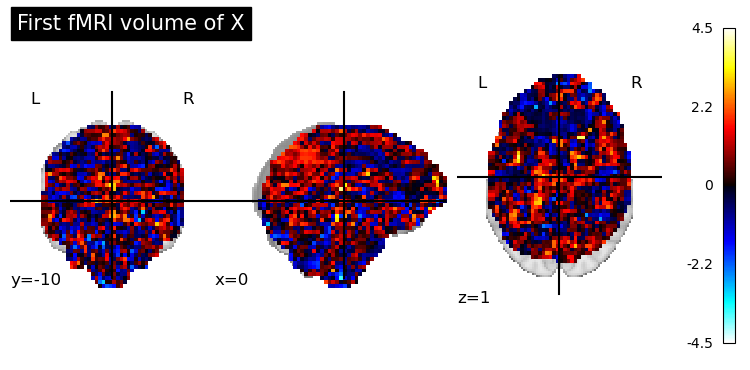


First 5 rows of X:
 [[ 0.69111603  3.210437    1.9961944  ...  0.76483     0.26460516
   1.3470215 ]
 [ 0.03183856  1.8330282   0.53699017 ...  0.05522097 -0.91839194
  -0.28928208]
 [-0.84448534  0.19465181  0.72767985 ...  1.1981351   0.26110956
   1.4098372 ]
 [-1.0294247  -1.3919485  -1.3682451  ... -0.32514268 -0.88887686
   0.13887714]
 [-0.396364    0.22978795  1.569099   ...  0.71279126 -0.31688282
   0.49756712]]

First 5 entries of y:
 6     scissors
7     scissors
8     scissors
9     scissors
10    scissors
Name: labels, dtype: object
Model files already exist. Loading models...


['haxby_svm_model_run.pkl']

In [2]:
import numpy as np
import pandas as pd

from nilearn import datasets
from nilearn.plotting import plot_matrix, show

# By default 2nd subject from haxby datasets will be fetched.
haxby_dataset = datasets.fetch_haxby(fetch_stimuli=True)

# Print basic information on the dataset
print(f"Mask nifti images are located at: {haxby_dataset.mask}")
print(f"Functional nifti images are located at: {haxby_dataset.func[0]}")

func_filename = haxby_dataset.func[0]
mask_filename = haxby_dataset.mask

# Load the behavioral data that we will predict
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
y = labels["labels"]
run = labels["chunks"]

# Remove the rest condition, it is not very interesting
non_rest = y != "rest"
y = y[non_rest]

# Get the labels of the numerical conditions represented by the vector y
unique_conditions, order = np.unique(y, return_index=True)
# Sort the conditions by the order of appearance
unique_conditions = unique_conditions[np.argsort(order)]

from nilearn.maskers import NiftiMasker

# For decoding, standardizing is often very important
nifti_masker = NiftiMasker(
    mask_img=mask_filename,
    standardize="zscore_sample",
    runs=run,
    smoothing_fwhm=4,
    memory="nilearn_cache",
    memory_level=1,
)
X = nifti_masker.fit_transform(func_filename)

# Remove the "rest" condition
X = X[non_rest]
run = run[non_rest]

from nilearn.plotting import plot_stat_map

# Print shapes
print("X shape:", X.shape)
print("y shape:", y.shape)

# Reconstruct the first volume back to a Nifti image
first_img = nifti_masker.inverse_transform(X[0])

# Plot it
plot_stat_map(first_img, display_mode="ortho", title="First fMRI volume of X")
show()

# Print first few entries
print("\nFirst 5 rows of X:\n", X[:5])
print("\nFirst 5 entries of y:\n", y.head())

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )

indices = np.random.permutation(len(X))

X = X[indices]
y = y.iloc[indices]
run = run.iloc[indices]

X_train = X[:int(len(X) * 0.8)]
X_test = X[int(len(X) * 0.8):]
y_train = y[:int(len(X) * 0.8)]
y_test = y[int(len(X) * 0.8):]
run_train = run[:int(len(X) * 0.8)]
run_test = run[int(len(X) * 0.8):]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# determine if model files exist
import os
import joblib
if os.path.exists("best_model.pth") and os.path.exists("haxby_svm_model_run.pkl"):
    print("Model files already exist. Loading models...")
    clf = CVAE(input_dim, latent_dim, num_classes=unique_conditions.shape[0])
    clf.load_state_dict(torch.load("best_model.pth"))
    clf.eval()
    clf = clf.to(device)
    clf_run = joblib.load("haxby_svm_model_run.pkl")
else:
    clf_run = SVC(kernel='rbf')
    clf_run.fit(X_train, run_train)

# Save models
import joblib
joblib.dump(clf_run, "haxby_svm_model_run.pkl")

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
stimuli = haxby_dataset.stimuli
stimuli.keys()

dict_keys(['houses', 'bottles', 'scissors', 'cats', 'chairs', 'faces', 'shoes', 'controls'])

In [5]:
set(y_train.values)

{'bottle', 'cat', 'chair', 'face', 'house', 'scissors', 'scrambledpix', 'shoe'}

In [6]:
input_size = 39912 + 64 + 1

def label_to_onehot(label):
    labels = list(set(y_train.values))
    out = np.zeros(len(labels))
    out[labels.index(label)] = 1
    return out

from torch.nn import ConvTranspose2d
from torch.nn import BatchNorm2d
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import LeakyReLU
from torch.nn import ReLU
from torch.nn import Tanh
from torch.nn import Sigmoid
from torch import flatten
from torch import nn

# Hyperparameters
image_size = 128
batch_size = 4
nz = input_size  # Latent size
ngf = 32
ndf = 64
nc = 1  # Grayscale
lr = 0.00001
beta1 = 0.5
epochs = 5

class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.seed_H, self.seed_W = 5, 5
        self.project = nn.Sequential(
            nn.Linear(nz, ngf * 8 * self.seed_H * self.seed_W),
            nn.ReLU(True)
        )

        self.main = nn.Sequential(
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1),  # 5x5 → 10x10
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1),  # 10x10 → 20x20
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1),      # 20x20 → 40x40
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(ngf, ngf, 4, 2, 1),          # 40x40 → 80x80
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(ngf, ngf, 4, 2, 1),          # 80x80 → 160x160
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(ngf, ngf, 4, 2, 1),          # 160x160 → 320x320
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(ngf, nc, 81, 1, 0),           # 320x320 → 400x400
            nn.Tanh()
        )

    def forward(self, input):
        x = self.project(input.view(input.size(0), -1))
        x = x.view(-1, 8 * ngf, self.seed_H, self.seed_W)
        return self.main(x)
    
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),  # 400 -> 200
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.5),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),  # 200 -> 100
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.5),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),  # 100 -> 50
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.5),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),  # 50 -> 25
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.5),

            nn.Conv2d(ndf * 8, 1, 18, 1, 0, bias=False),  # 25 -> 1
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1)


In [7]:
from torch import optim

netG = Generator(nz, ngf, nc).to(device)
netD = Discriminator(nc, ndf).to(device)

criterion = nn.BCELoss()
fixed_noise = torch.randn(16, nz, 1, 1, device=device)

optimizerD = optim.Adam(netD.parameters(), lr=0.00002)
optimizerG = optim.Adam(netG.parameters(), lr=0.0000002)

In [8]:
# make list of all scrambled images in stimuli
scrambled_stimuli = list(stimuli['controls']['scrambled_bottles']) \
                    + list(stimuli['controls']['scrambled_cats']) \
                    + list(stimuli['controls']['scrambled_chairs']) \
                    + list(stimuli['controls']['scrambled_faces']) \
                    + list(stimuli['controls']['scrambled_houses']) \
                    + list(stimuli['controls']['scrambled_scissors']) \
                    + list(stimuli['controls']['scrambled_shoes'])

In [9]:
type(run_train.values[0])

numpy.int64

In [ ]:
from PIL import Image

def img_from_y_run(y, run):
    if y == "scrambledpix":
        out =  np.array(Image.open(np.random.choice(scrambled_stimuli)))
    else:
        key = y + "s" if y != "scissors" else y
        idx = run * 4 + 2
        out = np.array(Image.open(stimuli[key][idx]))
    if out.shape != (400, 400):
        out = np.pad(out, ((0, 400 - out.shape[0]), (0, 400 - out.shape[1])), mode='constant', constant_values=0)
    # scale all values in out to [0, 1]
    for i in range(out.shape[0]):
        for j in range(out.shape[1]):
            if out[i, j] > 1.0:
                out = out / 255.0
                break
    return out

img_train = [img_from_y_run(y, run) for y, run in zip(y_train.values, run_train.values)]
img_test = [img_from_y_run(y, run) for y, run in zip(y_test.values, run_test.values)]
# X_train[i] + label_to_onehot(y_train.values[i]) + np.array(run_train.values[i])
with torch.no_grad():
    X_gan_train = [
        np.concatenate((
            X_train[i],
            clf.encode(torch.Tensor(X_train[i]).unsqueeze(0).to(device))[0].cpu().numpy().squeeze(),
            np.array([run_train.values[i]])
        ), axis=None)
        for i in range(len(X_train))
    ]
    X_gan_test = [
        np.concatenate((
            X_test[i],
            clf.encode(torch.Tensor(X_test[i]).unsqueeze(0).to(device))[0].cpu().numpy().squeeze(),
            np.array([run_test.values[i]])
        ), axis=None)
        for i in range(len(X_test))
    ]

In [11]:
for epoch in range(epochs):
    for i, (X_batch, img_batch) in enumerate(zip(X_gan_train, img_train)):
        X_batch = torch.tensor(X_batch)
        X_batch = X_batch.reshape((1, 39977))
        img_batch = torch.tensor(img_batch)
        img_batch = img_batch.reshape((1, 400, 400)).float().to(device)
        # Prepare real data
        real_images = img_batch.unsqueeze(1).to(device)  # (B, 1, 400, 400)
        b_size = real_images.size(0)

        # # Train Discriminator
        # netD.zero_grad()
        # output_real = netD(real_images)
        # label_real = torch.ones_like(output_real, device=device)
        # loss_D_real = criterion(output_real, label_real)

        # # Generate fake images
        # input_vectors = X_batch.float().to(device)
        # fake_images = netG(input_vectors)
        # output_fake = netD(fake_images.detach())
        # label_fake = torch.zeros_like(output_fake, device=device)
        # loss_D_fake = criterion(output_fake, label_fake)

        # loss_D = loss_D_real + loss_D_fake
        # loss_D.backward()
        # optimizerD.step()

        # # Train Generator
        # netG.zero_grad()
        # output_gen = netD(fake_images)
        # label_gen = torch.ones_like(output_gen, device=device)  # Try to fool D
        # loss_G = criterion(output_gen, label_gen)
        # loss_G.backward()
        # optimizerG.step()
        
        # Train Generator
        optimizerG.zero_grad()
        input_vectors = X_batch.float().to(device)
        fakes = netG(input_vectors).detach()
        discriminator_output = netD(fakes)
        g_loss = criterion(discriminator_output, torch.ones_like(discriminator_output, device=device))

        g_loss.backward()
        optimizerG.step()

        # Train Discriminator
        optimizerD.zero_grad()
        real_loss = criterion(netD(real_images), torch.ones_like(discriminator_output, device=device))
        fake_loss = criterion(netD(fakes), torch.zeros_like(discriminator_output, device=device))
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizerD.step()

        if i % 100 == 0:
            print(f"[{epoch}/{epochs}][{i}] Loss_D: {d_loss.item():.4f}, Loss_G: {g_loss.item():.4f}")

# Save models
torch.save(netG.state_dict(), "generator.pth")
torch.save(netD.state_dict(), "discriminator.pth")

[0/5][0] Loss_D: 0.8042, Loss_G: 0.7552
[0/5][100] Loss_D: 0.0533, Loss_G: 1.7518
[0/5][200] Loss_D: 0.0265, Loss_G: 2.9587
[0/5][300] Loss_D: 0.0100, Loss_G: 5.5558
[0/5][400] Loss_D: 0.0035, Loss_G: 7.8000
[0/5][500] Loss_D: 0.0021, Loss_G: 9.6383
[0/5][600] Loss_D: 0.0071, Loss_G: 7.6235
[1/5][0] Loss_D: 0.0095, Loss_G: 8.3181
[1/5][100] Loss_D: 0.0012, Loss_G: 6.0155
[1/5][200] Loss_D: 0.0009, Loss_G: 8.9361
[1/5][300] Loss_D: 0.0014, Loss_G: 7.1054
[1/5][400] Loss_D: 0.0020, Loss_G: 6.1532
[1/5][500] Loss_D: 0.0004, Loss_G: 7.4707
[1/5][600] Loss_D: 0.0013, Loss_G: 8.6435
[2/5][0] Loss_D: 0.0723, Loss_G: 9.6021
[2/5][100] Loss_D: 0.0002, Loss_G: 5.2378
[2/5][200] Loss_D: 0.0002, Loss_G: 11.0304
[2/5][300] Loss_D: 0.0005, Loss_G: 10.0087
[2/5][400] Loss_D: 0.0028, Loss_G: 13.3496
[2/5][500] Loss_D: 0.0002, Loss_G: 10.6889
[2/5][600] Loss_D: 0.0008, Loss_G: 11.4190
[3/5][0] Loss_D: 0.0068, Loss_G: 10.4730
[3/5][100] Loss_D: 0.0002, Loss_G: 11.8335
[3/5][200] Loss_D: 0.0002, Loss_G: 

KeyboardInterrupt: 

In [ ]:
from matplotlib import pyplot as plt

def generate_image_from_input(generator, input_vector, save_path=None, show=True):
    """
    Generate a 400x400 image from a 39918-dimensional input vector using the trained generator.

    Args:
        generator (nn.Module): Trained generator model.
        input_vector (torch.Tensor or np.ndarray): 1D input of shape (39918,)
        save_path (str): Optional path to save the generated image.
        show (bool): Whether to display the image using matplotlib.
    """
    generator.eval()

    # Ensure input is a tensor
    if isinstance(input_vector, np.ndarray):
        input_vector = torch.from_numpy(input_vector)

    # Reshape to (1, 39918, 1, 1)
    input_tensor = input_vector.float().view(1, 39977, 1, 1).to(next(generator.parameters()).device)

    # Generate image
    with torch.no_grad():
        generated_image = generator(input_tensor).cpu()  # Shape: (1, 1, 400, 400)

    return generated_image

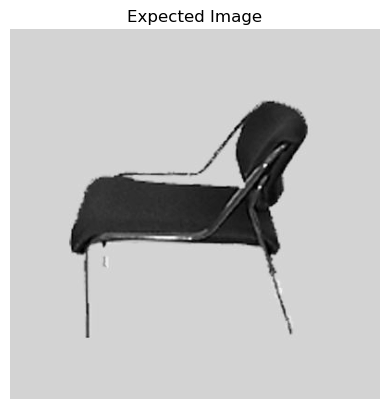

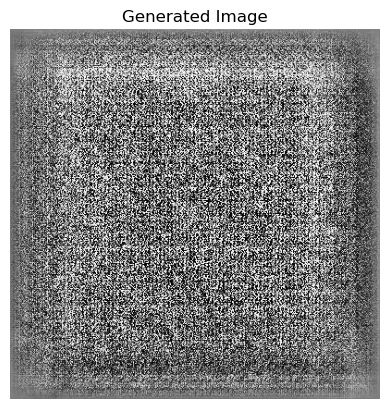

In [ ]:
expected = img_from_y_run(y_train.values[0], run_train.values[0])
actual = generate_image_from_input(netG, X_gan_train[0], show=False)

# show expected
plt.imshow(expected, cmap='gray')
plt.title("Expected Image")
plt.axis('off')
plt.show()

# show actual
plt.imshow(actual.squeeze().numpy(), cmap='gray')
plt.title("Generated Image")
plt.axis('off')
plt.show()